In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
train_path = "masked_data/training"
validation_path = "original_data/validation"
test_path = "original_data/test"

In [3]:
dimentions = (299, 299)
batch_size = 64

n_class = 2

In [4]:
train_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [5]:
valid_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 1427 images belonging to 2 classes.


In [7]:
validation_generator = valid_datagen.flow_from_directory(
    validation_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [8]:
test_generator = valid_datagen.flow_from_directory(
    test_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from keras.models import Model

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False,
)

x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
predictions = Dense(n_class, activation='softmax')(x)    
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
from keras import metrics

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
from keras.callbacks import ModelCheckpoint  

# !mkdir saved_models

model_file = 'saved_models/cropped_weights.best.InceptionV3.hdf5'
checkpointer = ModelCheckpoint(filepath=model_file, 
                               verbose=1, save_best_only=True)

In [12]:
epochs = 10

In [13]:
train_history = model.fit_generator(train_generator, 
                                    validation_data=validation_generator, 
                                    epochs=epochs, 
                                    callbacks=[checkpointer],
                                    steps_per_epoch=train_generator.samples // batch_size, 
                                    validation_steps=validation_generator.samples // batch_size
                                   )

Epoch 1/10
22/22 [==============================] - 158s 7s/step - loss: 0.2804 - acc: 0.9020 - val_loss: 0.7124 - val_acc: 0.4531

Epoch 00001: val_loss improved from inf to 0.71236, saving model to saved_models/cropped_weights.best.InceptionV3.hdf5
Epoch 2/10
22/22 [==============================] - 75s 3s/step - loss: 0.1290 - acc: 0.9489 - val_loss: 0.8258 - val_acc: 0.7886

Epoch 00002: val_loss did not improve from 0.71236
Epoch 3/10
22/22 [==============================] - 113s 5s/step - loss: 0.0986 - acc: 0.9621 - val_loss: 0.1177 - val_acc: 0.9657

Epoch 00003: val_loss improved from 0.71236 to 0.11770, saving model to saved_models/cropped_weights.best.InceptionV3.hdf5
Epoch 4/10
22/22 [==============================] - 114s 5s/step - loss: 0.0701 - acc: 0.9723 - val_loss: 2.1634 - val_acc: 0.5200

Epoch 00004: val_loss did not improve from 0.11770
Epoch 5/10
22/22 [==============================] - 115s 5s/step - loss: 0.1120 - acc: 0.9555 - val_loss: 0.5801 - val_acc: 0.692

In [14]:
train_history.history

{'val_loss': [0.712361752986908,
  0.8257663008144923,
  0.11769883287804467,
  2.163432797023228,
  0.5800972282886505,
  0.2721663214479174,
  2.304776199885777,
  0.9882238721847534,
  0.25349348364397883,
  1.5513217244829451],
 'val_acc': [0.453125,
  0.7885714207376753,
  0.9657142870766776,
  0.5199999982970102,
  0.6927083333333334,
  0.914285717691694,
  0.851428576196943,
  0.9257142884390694,
  0.96875,
  0.7028571357045855],
 'loss': [0.28044936297969386,
  0.11969321944306024,
  0.09697958730811682,
  0.07154106642157167,
  0.10531909082710787,
  0.07209923302020908,
  0.07520936215221226,
  0.04136552857897864,
  0.05761751858346705,
  0.03395553975778079],
 'acc': [0.9019886363636364,
  0.9523110785907625,
  0.9625825388240884,
  0.971386647101981,
  0.9574468082919859,
  0.9721203231234281,
  0.9743213497446638,
  0.9809244314013206,
  0.9779897283213329,
  0.9911958914159942]}

In [15]:
import matplotlib.pyplot as plt

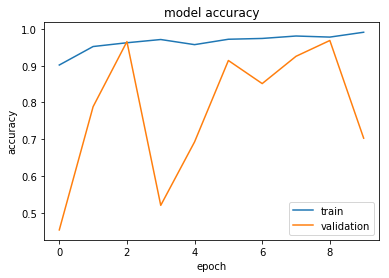

In [16]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

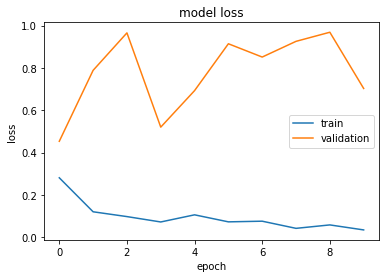

In [17]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
model.load_weights(model_file)
tesr_result = model.evaluate_generator(test_generator, steps=10)

In [19]:
tesr_result

[0.5895073659250839, 0.900990100780336]

In [20]:
predict = model.predict_generator(test_generator,steps = 10)

In [21]:
import cv2
import numpy as np


from keras.preprocessing import image
# img = cv2.imread(path_to_one_file)
# img = np.array([img]).reshape((1, 3, 299, 299))

def to_tensor(img_path): 
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 
    
    return img_tensor

In [22]:
def make_predict(img_path): 
    class_dic = {}
    for k, v in test_generator.class_indices.items():
        class_dic[v] = k
    
    
    y_prob = model.predict(to_tensor(img_path))
    y_classes = y_prob.argmax(axis=-1)
    return class_dic[y_classes[0]]

In [23]:
img_path = "original_data/test/benign/ISIC_0004472.jpg"
make_predict(img_path)

'benign'

In [24]:
class_dic = dict(test_generator.class_indices)
print(class_dic)

one_hot = {}
for k, v in test_generator.class_indices.items():
    one_hot[v] = k
print(one_hot)

{'benign': 0, 'malignant': 1}
{0: 'benign', 1: 'malignant'}


In [25]:
from os import listdir 

y_true = [] 
y_pred = []

class_name = "benign"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    
class_name = "malignant"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    

In [26]:
len(y_true) == len(y_pred)

True

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["benign", "malignant"])

In [28]:
import pandas as pd
df_cm = pd.DataFrame(cm, ["benign", "malignant"], ["benign", "malignant"])

In [29]:
import seaborn as sn

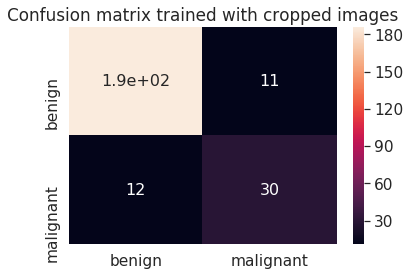

In [30]:
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}).set_title("Confusion matrix trained with cropped images")# font size
plt.show()

In [31]:
from sklearn.metrics import f1_score
y_true_01 = [class_dic[p] for p in y_true]
y_pred_01 = [class_dic[p] for p in y_pred]
f1_score(y_true_01, y_pred_01)

0.7228915662650603

In [32]:
from sklearn.metrics import recall_score
recall_score(y_true_01, y_pred_01) 

0.7142857142857143

In [33]:
from sklearn.metrics import precision_score
precision_score(y_true_01, y_pred_01) 

0.7317073170731707

In [34]:
# y_pred_01